For this project, you will interpret data from the National Parks Service about endangered species in different parks.

You will perform some data analysis on the conservation statuses of these species and investigate if there are any patterns or themes to the types of species that become endangered. During this project, you will analyze, clean up, and plot data as well as pose questions and seek to answer them in a meaningful way.

After you perform your analysis, you will share your findings about the National Park Service.

Scoping Project

1) Import and review data for project
2) Analyze the data and begin to develop questions
3) Conduct analysis to answer the questions posed above
4) Summarize the findings of your answers to these questions

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [50]:
# ingest raw data
obs_df = pd.read_csv('observations.csv', skipinitialspace=True)
spec_df = pd.read_csv('species_info.csv', skipinitialspace=True)

# clean up data frames

''' We see multiple recorded observations for one location and species type (ex: Echinochloa crus-galli @ 
Bryce has obs of 112 and 116). To err on the side of caution, this report is going to be considering the 
lowest of all of the values for specific species/ location combinations (e.g: 112 from the above example.)'''

# sort by the number of observations (smaller first), then keep smallest of duplicates
obs_df = obs_df.sort_values('observations', ascending=True).drop_duplicates(['scientific_name', 'park_name'], keep= 'first').sort_index() # from https://stackoverflow.com/questions/12497402/remove-duplicates-by-columns-a-keeping-the-row-with-the-highest-value-in-column/68876659#68876659


''' We also see multiple duplicates in the species information. Upon review, we have multiple common names 
and conservation statuses for a single species (ex: Canis lupus is both endangered and in recovery). In a 
similar approch, this analysis will bias towards caution -- marking a species as Endangered rather than 
In Recovery when there is a conflict. All common names have been combined to keep their values intact.'''

# combine all common names for each scientific name
spec_names = spec_df.groupby(['scientific_name'])['common_names'].apply(', '.join).reset_index() # from https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby

# assign all common names back to species data frame
spec_df = pd.merge(spec_df, spec_names, on= 'scientific_name', how= 'left')

# drop old common names column
spec_df = spec_df.drop(columns= 'common_names_x')

# rename new common names column
spec_df.rename(columns= {'common_names_y': 'common_names'}, errors="raise", inplace= True)

# remove redundant names from common names column
spec_df['common_names'] = spec_df['common_names'].str.replace(' ,', ',')
spec_df['common_names'] = spec_df['common_names'].str.replace(', ', ',')
spec_df['common_names']=spec_df['common_names'].str.split(',').apply(lambda x : ', '.join(set(x)))

# encode data to enable sorting by conservation status for duplicates (Endangered > Threatened > Species of Concern > In Recovery > None)
spec_df['conservation_status'] = spec_df['conservation_status'].replace(np.nan, 'None')
spec_df['conservation_group'] = pd.Categorical(spec_df['conservation_status'], ordered=True, categories=['None', 'In Recovery', 'Species of Concern', 'Threatened', 'Endangered'])

# drop duplicate species keeping the most conservative level in conservation group
spec_df = spec_df.sort_values('conservation_group', ascending=True).drop_duplicates(['scientific_name'], keep= 'last')

# drop column used for sorting
spec_df = spec_df.drop('conservation_group', 1)
spec_df.to_csv('spec_df.csv')

# combine all data into single data frame
bio_df = pd.merge(spec_df, obs_df, on= 'scientific_name', how= 'left')

# confirm merge using original csvs # confirmed
# bio_df[bio_df['conservation_status'] == 'Endangered'].head(10)

bio_df.head()
bio_df.to_csv('bio_df.csv')

#### Data

I should describe the errata in the data more.

After cleaning the data, there are 22,164 observations with 5,541 scientific names (5,236 lists of common names). Observations of these species span 7 categories, 5 conservation statuses, and 4 parks. The bulk of the species (96.8%) are in no conservation group (meaning they are not a in recovery, a species of concern, threatened, or endangered). Of those which are in a group (do have a conservation status); 12 (0.1%) are in recovery, 604 (2.7%) are species of concern, 40 (0.2%) are threatened, and 60 (0.3%) are endangered.

The most common category was vascular plants at 76.9% of the species, followed by birds at 8.8%. Nonvascular plants made up 6.0% of the species, with the remaining four categories (mammal, fish, amphibian, and reptile) constituting the remaining 8.3%.

The median number of all obeservations across all species and parks is 124, with a minimum of 9, and a maximum of 321.

# Playing with groupby

In [26]:
# sum observations by category
category_obs = bio_df.groupby('category')[['observations']].sum()
category_obs

observations
category                       
Amphibian                 43375
Bird                     272798
Fish                      69568
Mammal                    94094
Nonvascular Plant        190653
Reptile                   44082
Vascular Plant          2426750

In [27]:
# sum observations by status
status_obs = bio_df.groupby('conservation_status')[['observations']].sum()
status_obs

observations
conservation_status              
Endangered                   2219
In Recovery                  1392
None                      3057921
Species of Concern          76986
Threatened                   2802

In [30]:
# sum observations by park
park_obs = bio_df.groupby('park_name')[['observations']].sum()
park_obs

observations
park_name                                        
Bryce National Park                        544913
Great Smoky Mountains National Park        407679
Yellowstone National Park                 1370369
Yosemite National Park                     818359

In [61]:
# create a df of the park acreage 
park_acres = {'acres': [35835, 407679, 2219791, 747956]}
park_labels = ['Bryce National Park', 'Great Smoky Mountains National Park', 'Yellowstone National Park', 'Yosemite National Park']
park_size_df = pd.DataFrame(park_acres, index= park_labels)
park_size_df.index.name = 'park_name'
park_size_df

acres
park_name                                   
Bryce National Park                    35835
Great Smoky Mountains National Park   407679
Yellowstone National Park            2219791
Yosemite National Park                747956

In [49]:
# count species by category
# category_species_count = bio_df.groupby(['category'])[['scientific_name']].count()
# the above doesn't work as all species are accounted for in each park. in order to get the true number, we would have
# to divide the count by 4, or groupby on the spec_df dataset. the latter feels better than using a scalar.

category_species_count = spec_df.groupby('category')[['scientific_name']].count()
category_species_count

scientific_name
category                          
Amphibian                       79
Bird                           488
Fish                           125
Mammal                         176
Nonvascular Plant              333
Reptile                         78
Vascular Plant                4262

In [42]:
# count species by status
status_species_count = spec_df.groupby('conservation_status')[['scientific_name']].count()
status_species_count

scientific_name
conservation_status                 
Endangered                        15
In Recovery                        3
None                            5362
Species of Concern               151
Threatened                        10

In [45]:
# count species by park # if my theory is correct, these should be the same
park_species_count = bio_df.groupby('park_name')[['scientific_name']].count()
park_species_count

# they are the same. the theory is correct.

scientific_name
park_name                                           
Bryce National Park                             5541
Great Smoky Mountains National Park             5541
Yellowstone National Park                       5541
Yosemite National Park                          5541

#### Plot the Count of Conservation Groups

# What are the best data viz techniques for cross sectional data?

In [6]:
# plot_df = spec_df[spec_df['conservation_status'] != 'None']

spec_df

# f, ax = plt.subplots(figsize=(15, 10))
# sns.countplot(data= plot_df, x= 'conservation_status', order = plot_df['conservation_status'].value_counts().index)
# plt.title('Count of Species in Conservation Status')

Unnamed: 0  22164 Unnamed: 2                None  21448 96.8%
0                  NaN    NaN        NaN         In Recovery   12.0  0.1%
1                  NaN    NaN        NaN  Species of Concern  604.0  2.7%
2                  NaN    NaN        NaN          Threatened   40.0  0.2%
3                  NaN    NaN        NaN          Endangered   60.0  0.3%
4                  NaN    NaN        NaN                 NaN    NaN   NaN
5                  NaN    NaN        NaN                 NaN    NaN   NaN
6                  NaN    NaN        NaN                 NaN    NaN   NaN
7                  NaN    NaN        NaN                 NaN    NaN   NaN
8                  NaN    NaN        NaN                 NaN    NaN   NaN
9                  NaN  22164        NaN                 NaN    NaN   NaN
10      Vascular Plant  17048      76.9%                 NaN    NaN   NaN
11                Bird   1952       8.8%                 NaN    NaN   NaN
12   Nonvascular Plant   1332       6.0%                 NaN    NaN   NaN
13              Mammal    704       3.2%                 NaN    NaN   NaN
14                Fish    500       2.3%                 NaN    NaN   NaN
15           Amphibian    316       1.4%                 NaN    NaN   NaN
16             Reptile    312       1.4%                 NaN    NaN   NaN
17                 NaN    NaN        NaN                 NaN    NaN   NaN
18                 NaN    NaN        NaN                 NaN    NaN   NaN
19                 NaN    NaN        NaN                 NaN    NaN   NaN
20                 NaN   5541       0.25                 NaN    NaN   NaN
21                 NaN    NaN        NaN                 NaN    NaN   NaN
22                 NaN    NaN        NaN                 NaN    NaN   NaN
23                 NaN    NaN        NaN                 NaN    NaN   NaN
24                 NaN    NaN        NaN                 NaN    NaN   NaN
25                 NaN    NaN        NaN                 NaN    NaN   NaN
26  Conservation Group  Count        NaN                 NaN    NaN   NaN
27         In Recovery      4        NaN                 NaN    NaN   NaN
28  Species of Concern    161        NaN                 NaN    NaN   NaN
29          Threatened     10        NaN                 NaN    NaN   NaN
30          Endangered     16        NaN                 NaN    NaN   NaN

#### Plot the Count of Categories

<AxesSubplot:xlabel='category', ylabel='count'>

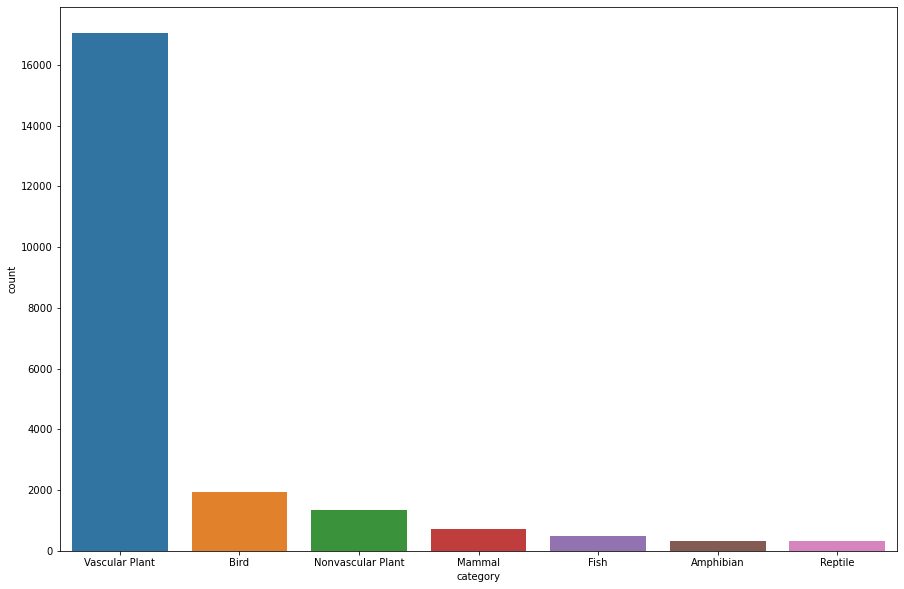

In [47]:
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data= plot_df, x= 'category', order = 
      bio_df['category'].value_counts().index)

#### Plot Number of Observations of Each Conservation Group

#### Questions:

##### What is a 'good' (bad, great) amount of observations?
Maybe total and median amount of observations per category?

##### Do we see a relationship between the number of observations being low and troubled species?
Bar plots of the median number of observations by category by status

##### How we identify troubled species within a category using observations
One s.d. down from the median and below?

##### Which parks house the most troubled species, and in which category?
How do the species counts compare of conservation groups compare across parks

##### Which species are the most troubled , and in which park?
Which species seem to be the worst off based on species count and conservation status

##### Which category is most troubled?
Of the categories available, which are most threatened (as a percentage of their total population)?

##### Which species is most troubled?
Of all of the species that we see, which seem to be the most precarious?

### What is a 'good' amount of observations?

Text(0.5, 1.0, 'Observations by Category')

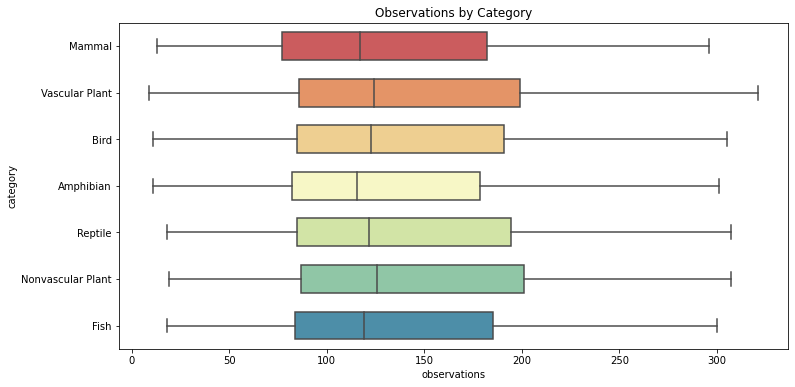

In [56]:
# What is a 'good' (bad, great) amount of observations?
# Create a boxplot of observations on the x-axis, and categories on the y-axis

f, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(x= 'observations', y= 'category', data=bio_df, width=.6, palette= 'Spectral')
plt.title('Observations by Category')


Text(0.5, 1.0, 'Observations by Conservation Staus')

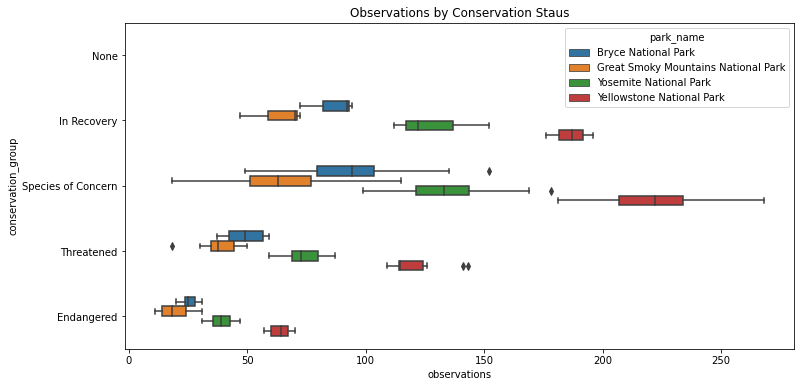

In [62]:
f, ax = plt.subplots(figsize=(12, 6))
bio_df_troubled = bio_df.loc[bio_df['conservation_group'] != 'None']
sns.boxplot(x= 'observations', y= 'conservation_group', data=bio_df_troubled, hue ='park_name', width=.6)
plt.title('Observations by Conservation Staus')